In [5]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
from pylab import plot, show, savefig
from scipy import stats
#%pylab inline

In [14]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-10-21/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 2186
files_end = 2326


In [33]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "126"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124"], ["117", "118", "119", "122", "124"]]
isotopes = [["112", "114", "115", "116", "117", "118", "119", "122", "124"]]
#isotopes = [["116", "117", "118", "119", "122", "124"]]
denom_isotope = "120"
isotope_column = ["112", "114", "115", "116", "117", "118", "119", "122", "124"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
print data_sample_column
#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = True

blk_corr = True

['112/120', '114/120', '115/120', '116/120', '117/120', '118/120', '119/120', '122/120', '124/120']


In [34]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
for sample in files_1:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_zero_2 = df_zero_2[columns_2]
    df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    #df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "teflon blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)
df_all
#for x in [123]:
#    sample_ls.remove(x)
#blk_ls

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),...,H5 (2),H4 (2),H3 (2),H2 (2),H1 (2),Ax (2),L1 (2),L2 (2),L3 (2),L4 (2)
date,,,,,,,,,,,,,,,,,,,,,
2015-10-21 18:36:00,1,blank sol,0.000560,0.000395,0.003276,0.000719,0.002019,0.000636,0.001190,0.000071,...,0.000039,3.664500e-06,0.000628,0.000206,0.000501,0.000229,0.003832,0.000873,0.002383,0.000780
2015-10-21 18:36:00,2,blank sol,0.000537,0.000392,0.003017,0.000691,0.001818,0.000589,0.001115,0.000049,...,0.000069,2.509510e-05,0.000554,0.000252,0.000402,0.000284,0.003394,0.000740,0.002092,0.000691
2015-10-21 18:36:00,3,blank sol,0.000505,0.000367,0.002880,0.000612,0.001704,0.000550,0.001024,0.000095,...,0.000045,-2.580800e-06,0.000370,0.000171,0.000282,0.000227,0.002299,0.000445,0.001272,0.000421
2015-10-21 18:36:00,4,blank sol,0.000431,0.000297,0.002607,0.000481,0.001524,0.000488,0.000887,0.000046,...,0.000051,1.170700e-05,0.000401,0.000208,0.000288,0.000238,0.002590,0.000539,0.001539,0.000474
2015-10-21 18:36:00,5,blank sol,0.000498,0.000327,0.002802,0.000573,0.001689,0.000563,0.001011,0.000054,...,0.000053,-7.950000e-07,0.000533,0.000161,0.000392,0.000244,0.003354,0.000729,0.002006,0.000641
2015-10-21 18:36:00,6,blank sol,0.000519,0.000371,0.002973,0.000617,0.001741,0.000595,0.001049,0.000044,...,0.000041,6.346800e-06,0.000632,0.000173,0.000454,0.000262,0.003483,0.000790,0.002154,0.000665
2015-10-21 18:36:00,7,blank sol,0.000524,0.000373,0.002977,0.000641,0.001784,0.000570,0.001070,0.000065,...,0.000057,2.598850e-05,0.000352,0.000170,0.000270,0.000205,0.002338,0.000501,0.001343,0.000408
2015-10-21 18:36:00,8,blank sol,0.000623,0.000452,0.003516,0.000796,0.002148,0.000707,0.001299,0.000085,...,0.000080,2.062640e-05,0.000448,0.000215,0.000272,0.000207,0.002462,0.000484,0.001410,0.000491
2015-10-21 18:36:00,9,blank sol,0.000452,0.000328,0.002760,0.000594,0.001589,0.000518,0.000988,0.000032,...,0.000047,2.420570e-05,0.000366,0.000147,0.000258,0.000200,0.002253,0.000472,0.001207,0.000389


In [35]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = data_sample_raw[np.abs(data_sample_raw-data_sample_raw.mean())<=(2*data_sample_raw.std())]
    
    data_sample = new_corr.internal_norm_1(denom_isotope, 10)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = data_sample[np.abs(data_sample-data_sample.mean())<=(2*data_sample.std())]
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)

Iterative Beta Correction Failed! --> beta_temp before iteration used


ValueError: math domain error

In [20]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_all_sub = df_all[(df_all["sample"] != "blank sol") & (df_all["sample"] != "SQ")]
df_internal_sub["111"] = df_all_sub["L3 (1)"]
df_internal_sub["125"] = df_all_sub["H5 (2)"]
df_internal_sub["Cd/Sn"] = (df_all_sub["L3 (1)"]/12.722)/(df_all_sub["H4 (1)"]/24.223)
df_internal_sub["Te/Sn"] = (df_all_sub["H5 (2)"]/7.0509)/(df_all_sub["H4 (1)"]/24.223)
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [21]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SE])
df_internal_norm_mean["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
#df_internal_norm_mean = df_internal_norm_mean[1:]
#df_internal_norm_mean = df_internal_norm_mean.drop(datetime.strptime("20150310 23:59", "%Y%m%d %H:%M"))
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:]
df_internal_norm_mean
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,112,...,118,119,120,122,124,111,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2015-10-21 18:45:00,0.029821,0.020182,0.010365,0.446,0.235299,0.742904,0.263447,0.142074,0.177536,0.215607,...,5.827759,2.094312,8.055034,1.174648,1.505974,0.000066,0.000030,0.000022,0.000018,NIST 100ppb
2015-10-21 18:58:00,0.029816,0.020178,0.010367,0.446,0.235298,0.742910,0.263441,0.142074,0.177536,0.215353,...,5.821601,2.092099,8.046809,1.173467,1.504526,0.000081,0.000050,0.000027,0.000029,NIST 100ppb
2015-10-21 19:10:00,0.029825,0.020188,0.010365,0.446,0.235301,0.742904,0.263444,0.142071,0.177532,0.211656,...,5.720484,2.055732,7.906710,1.152983,1.478175,0.000050,0.000041,0.000017,0.000027,NIST 100ppb
2015-10-21 19:22:00,0.029819,0.020179,0.010364,0.446,0.235302,0.742909,0.263442,0.142072,0.177526,0.215997,...,5.837137,2.097591,8.067513,1.176385,1.508047,0.000078,0.000043,0.000025,0.000025,NIST 100ppb
2015-10-21 19:34:00,0.029824,0.020187,0.010366,0.446,0.235299,0.742908,0.263444,0.142074,0.177531,0.203850,...,5.506022,1.978468,7.608670,1.109326,1.421915,0.000056,0.000056,0.000020,0.000038,NIST 100ppb
2015-10-21 19:56:00,0.029823,0.020183,0.010366,0.446,0.235300,0.742915,0.263438,0.142074,0.177534,0.180950,...,4.888662,1.756658,6.756175,0.985117,1.262822,0.000056,0.000041,0.000022,0.000033,NIST 100ppb
2015-10-21 20:08:00,0.029821,0.020182,0.010364,0.446,0.235298,0.742909,0.263442,0.142074,0.177534,0.208402,...,5.630480,2.023236,7.781272,1.134568,1.454392,0.000068,0.000049,0.000023,0.000030,NIST 100ppb
2015-10-21 20:25:00,0.029822,0.020180,0.010367,0.446,0.235304,0.742908,0.263444,0.142072,0.177530,0.214029,...,5.778391,2.076197,7.984111,1.163900,1.491689,0.000077,0.000067,0.000026,0.000040,NIST 100ppb
2015-10-21 20:37:00,0.029824,0.020184,0.010365,0.446,0.235302,0.742903,0.263443,0.142073,0.177528,0.203265,...,5.488887,1.972190,7.584498,1.105711,1.417195,0.000055,0.000039,0.000021,0.000024,NIST 100ppb


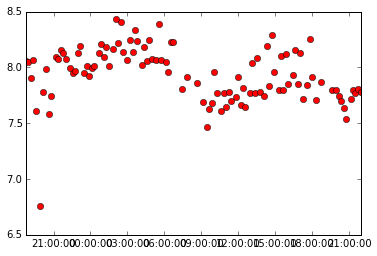

In [22]:
#plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 100ppb"]
plot_Nist = df_internal_norm_mean[(df_internal_norm_mean["118"] >= .5)]
#dataplot = plot(plot_Nist["Te/Sn"], plot_Nist["124/120"], "ro")
dataplot = plot(plot_Nist.index, plot_Nist["120"], "ro")
show(dataplot)

In [29]:
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == "NIST 100ppb")].index
#corr_values = df_internal_norm_mean[(df_external_norm_mean >= 0.74289)]
#corr_values = df_internal_norm_mean[:"20150110 10:00"]
corr_values = df_internal_norm_mean[df_internal_norm_mean["118"] >= 1]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
std_mean = corr_values[(corr_values["sample"] == "NIST 100ppb")].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
epsilon_2 = ((new / ((new.shift(2) + new.shift(-2))/2))-1)*10000
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#new[new.sample != "NIST 100ppb"]
epsilon_2 = epsilon_2[epsilon_2["sample"] == "NIST 100ppb"]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=True)
epsilon_comp

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,112,...,118,119,120,122,124,111,125,Cd/Sn,Te/Sn,sample
0,-2.444995,-3.265897,1.538156,0.000000e+00,-0.089169,0.072974,-0.189529,0.092799,0.114848,80.583460,...,82.227630,82.294937,82.618810,82.926961,83.452911,4048.568337,4044.562867,3699.819066,3048.125777,NIST 100ppb
1,2.615412,4.651119,-0.364537,0.000000e+00,0.029876,-0.070319,0.115750,-0.128603,0.050490,-186.352277,...,-186.786401,-186.708359,-186.729505,-186.757421,-186.629400,-3690.623804,-1163.992680,-3308.525667,-0.730170,NIST 100ppb
2,-1.876780,-4.462808,-1.176048,0.000000e+00,0.082645,0.041872,-0.089364,0.000486,-0.332627,396.810354,...,398.848525,399.043013,399.374944,399.859252,400.001971,4646.424676,-1120.105540,3656.887255,-2230.436915,NIST 100ppb
3,1.019616,3.359000,0.754099,0.000000e+00,-0.072797,-0.058934,0.160789,0.013306,0.075813,270.906528,...,266.875494,266.423334,265.556405,264.399928,263.315627,-1625.488897,3217.021736,-1649.868192,3013.498035,NIST 100ppb
4,0.209257,-0.984723,0.569260,0.000000e+00,0.067203,0.093321,-0.193461,0.034219,0.101459,-1221.413140,...,-1220.471344,-1220.448154,-1220.012234,-1219.573127,-1219.142979,-1006.527346,-2127.777718,231.825016,-382.281397,NIST 100ppb
5,-0.569780,0.337892,-1.665623,0.000000e+00,-0.178920,-0.035815,0.027329,0.071949,0.087348,552.584454,...,556.767745,557.329286,557.829853,558.943423,560.072283,197.249952,-934.539072,-300.325408,-1707.941161,NIST 100ppb
6,-0.146909,-1.476750,1.951264,0.000000e+00,0.175528,0.028795,0.069949,-0.103451,-0.052899,398.166764,...,393.381544,392.871234,392.074924,390.676035,389.299480,2587.127862,5333.184241,1763.339131,4743.735468,NIST 100ppb
7,0.540720,1.631270,-0.663970,0.000000e+00,-0.012336,-0.121294,-0.048062,0.186938,-0.242311,-358.953314,...,-357.777533,-357.791105,-357.445197,-356.993088,-356.753343,-2397.744961,-3789.456480,-1712.159667,-3647.467924,NIST 100ppb
8,-0.423329,-1.508849,-1.327910,0.000000e+00,-0.002673,0.099986,0.122133,-0.260776,0.256415,-112.510099,...,-115.184392,-115.419447,-115.955078,-116.887880,-117.499401,1734.518799,2920.998214,1860.953426,3561.331816,NIST 100ppb
9,0.279850,1.190896,0.080799,0.000000e+00,-0.023173,-0.051449,0.097138,0.125823,-0.090718,-60.335010,...,-64.893655,-64.823309,-65.003440,-61.974967,-60.984634,-861.042917,490532.840195,-827.024258,492667.661908,NIST 100ppb + Te 0.2ppb


In [30]:
def SD2(x):
    SD2 = np.std(x) * 2
    return SD2

epsilon = epsilon_comp.drop(["111", "125", "112", "114", "115", "116", "117", "118", "119", "120", "122", "124", "Cd/Sn", "Te/Sn"], axis = 1)
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2]), decimals=2)
epsilon_sum

112/120       114/120       115/120       116/120  \
                            mean   SD2    mean   SD2    mean   SD2    mean   
sample                                                                       
NIST 100ppb                -0.04  1.64   -0.18  3.32   -0.10  2.83       0   
NIST 100ppb + Cd 0.03ppb    0.74  0.39    1.56  1.32    0.24  2.40       0   
NIST 100ppb + Cd 0.05ppb   -0.13  0.46    2.35  0.15   -0.05  4.56      -0   
NIST 100ppb + Cd 0.07ppb   -0.24  2.25    2.45  2.35    0.67  1.36       0   
NIST 100ppb + Cd 0.15ppb    2.44  0.72    7.35  0.68    0.22  2.85       0   
NIST 100ppb + Cd 0.1ppb    -0.15  1.56    3.72  1.67    1.34  1.54       0   
NIST 100ppb + Te 0.2ppb    -0.02  1.85   -0.40  4.53   -0.26  1.46       0   
NIST 100ppb + Te 0.5ppb     1.01  0.17    0.06  0.52   -0.94  2.66       0   
NIST 100ppb + Te 1ppb      -0.34  0.07    1.07  2.66   -0.13  1.47       0   
NIST 100ppb + Te 2ppb       0.58  0.11   -0.17  2.71    0.01  0.54       0   
NIST 100ppb + Te 4ppb       0.53  2.77    0.90  1.90   -0.19  1.60       0   
NIST 100ppb + Te 8ppb       0.48  0.63   -0.66  1.24    0.40  0.99       0   
NIST 100ppb + U 0.003ppb    0.17  1.44   -0.40  0.76   -0.61  0.79       0   
NIST 100ppb + U 0.005ppb    0.24  0.43   -0.98  2.14   -0.25  0.16       0   
NIST 100ppb + U 0.01ppb    -1.30  0.76   -2.27  0.29    6.89  1.10       0   
NIST 100ppb + U 0.03ppb     0.83  0.04    1.47  2.43   -0.59  2.43       0   

                             117/120       118/120       119/120        \
                         SD2    mean   SD2    mean   SD2    mean   SD2   
sample                                                                   
NIST 100ppb                0    0.01  0.25    0.01  0.16   -0.01  0.23   
NIST 100ppb + Cd 0.03ppb   0    0.07  0.20   -0.02  0.03    0.04  0.21   
NIST 100ppb + Cd 0.05ppb   0   -0.06  0.33   -0.04  0.01    0.06  0.02   
NIST 100ppb + Cd 0.07ppb   0   -0.03  0.08   -0.03  0.01    0.08  0.12   
NIST 100ppb + Cd 0.15ppb   0   -0.02  0.03   -0.12  0.06    0.04  0.04   
NIST 100ppb + Cd 0.1ppb    0   -0.06  0.06   -0.07  0.06    0.01  0.25   
NIST 100ppb + Te 0.2ppb    0   -0.08  0.13   -0.02  0.06    0.04  0.08   
NIST 100ppb + Te 0.5ppb    0   -0.05  0.26    0.00  0.06   -0.03  0.09   
NIST 100ppb + Te 1ppb      0   -0.20  0.05   -0.02  0.07   -0.03  0.18   
NIST 100ppb + Te 2ppb      0   -0.04  0.01   -0.02  0.17   -0.10  0.06   
NIST 100ppb + Te 4ppb      0   -0.11  0.08   -0.15  0.11   -0.12  0.08   
NIST 100ppb + Te 8ppb      0   -0.04  0.08   -0.36  0.17   -0.28  0.03   
NIST 100ppb + U 0.003ppb   0   -0.00  0.07    0.04  0.06    0.19  0.13   
NIST 100ppb + U 0.005ppb   0   -0.01  0.05    0.01  0.07    0.29  0.06   
NIST 100ppb + U 0.01ppb    0   -0.04  0.02    0.14  0.02    0.03  0.20   
NIST 100ppb + U 0.03ppb    0   -0.07  0.19    0.04  0.12    0.91  0.02   

                         122/120       124/120        
                            mean   SD2    mean   SD2  
sample                                                
NIST 100ppb                 0.03  0.42    0.04  0.55  
NIST 100ppb + Cd 0.03ppb    0.14  0.29    0.10  0.25  
NIST 100ppb + Cd 0.05ppb    0.04  0.19    0.20  0.07  
NIST 100ppb + Cd 0.07ppb    0.21  0.28    0.20  0.51  
NIST 100ppb + Cd 0.15ppb    0.14  0.26    0.12  0.41  
NIST 100ppb + Cd 0.1ppb     0.08  0.25    0.16  0.03  
NIST 100ppb + Te 0.2ppb    -0.10  0.32   -0.22  0.18  
NIST 100ppb + Te 0.5ppb    -0.10  0.49   -0.16  0.03  
NIST 100ppb + Te 1ppb       0.02  0.17    0.02  0.20  
NIST 100ppb + Te 2ppb      -0.38  0.09   -0.26  0.02  
NIST 100ppb + Te 4ppb      -0.45  0.19   -0.57  0.33  
NIST 100ppb + Te 8ppb      -1.14  0.03   -1.11  0.06  
NIST 100ppb + U 0.003ppb    0.01  0.35    0.07  0.35  
NIST 100ppb + U 0.005ppb   -0.04  0.08   -0.01  0.11  
NIST 100ppb + U 0.01ppb    -0.16  0.04   -0.08  0.19  
NIST 100ppb + U 0.03ppb    -0.02  0.34   -0.07  0.51

In [31]:
x = range(1, len(epsilon_sum.index)+1)
errorbar(epsilon_sum["112/118"]["mean"], x, xerr = epsilon_sum["112/118"]["SD2"], ls='none', marker="o")
title("all standards")
xlim([-4, 4])
ylim([0.5, 2.5])
yticks(x, epsilon_sum.index, size='small', rotation=0)
ylabel(r'$\mathregular{\epsilon^{112}}$Sn$_{SPEX}$')
#savefig(path_sav+"epsilon_124_stds.pdf", bbox_inches='tight')

KeyError: '112/118'

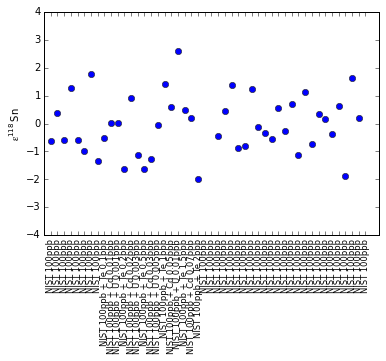

In [133]:
x = range(1, len(epsilon_comp["sample"])+1)
plot(x, epsilon_comp["112/120"], marker="o", ls="none")
ylim([-4, 4])
xticks(x, epsilon_comp["sample"], size='small', rotation=90)
ylabel(r'$\mathregular{\epsilon^{118}}$Sn')
#savefig(path+"epsilon_119.pdf", bbox_inches='tight')

In [194]:
df_all.to_csv(path_sav + "Sn_H9_L4_1_cycles_NU_Signals_zero_corr.csv", mode='a', header=False)

In [195]:
df_internal_sub.to_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm.csv", mode='a', header=False)

In [32]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_mean_rel_to_120__116_120_no_bgd_corr.csv", mode='w', header=True)

In [1226]:
df_std.to_csv(path_sav + "All_standards_internal_norm_mean.csv")

In [986]:
df_all_mean_1 = pd.read_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv")

In [987]:
df_all_mean_2 = pd.read_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm_mean.csv")

In [1088]:
df_mean_all = df_all_mean_1.append(df_all_mean_2)

In [1089]:
df_mean_all = df_mean_all[2:]
df_mean_all.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
df_mean_all = df_mean_all[["Date", "112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118","sample"]]
df_mean_all = df_mean_all.set_index("Date") 

In [1182]:
df_std = df_mean_all[(df_mean_all["sample"] == "SPEX1 100ppb") | (df_mean_all["sample"] == "SPEX 100ppb") | (df_mean_all["sample"] == "NIST 100ppb")]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 20:49:00,0.0298238495726,0.0201845997439,0.0103681594438,0.446,0.235295696368,0.742939518097,0.263445942562,0.142086185109,0.177571556759,10.1619395381,SPEX1 100ppb
2014-10-07 21:07:00,0.0298270855009,0.0201887834143,0.0103664239291,0.446,0.235295260593,0.742937654621,0.263447680516,0.14208571056,0.177573088542,10.2834847296,SPEX1 100ppb
2014-10-07 21:29:00,0.0298241010738,0.0201850728708,0.0103667030734,0.446,0.235295046713,0.742937732217,0.263449417694,0.142085954225,0.17757007419,10.0068814188,SPEX1 100ppb
2014-10-07 21:46:00,0.0298269719657,0.0201827454973,0.0103676568054,0.446,0.235297077525,0.742936157145,0.263450048386,0.142089277895,0.177573191934,10.1732362802,SPEX1 100ppb
2014-11-18 18:22:00,0.0298319477344,0.0201968060654,0.0103609914838,0.446,0.235308007067,0.74295144542,0.263456437295,0.142073025422,0.17753393783,11.9205622223,NIST 100ppb
2014-11-18 18:27:00,0.0298302415426,0.0202014506204,0.0103609667001,0.446,0.235304600881,0.742949759778,0.263451222795,0.142074064497,0.177531032284,11.8435340427,NIST 100ppb
2014-11-18 18:31:00,0.029834566445,0.0202024281122,0.0103608586407,0.446,0.235309236679,0.742955467382,0.263452936054,0.142073215452,0.177533064574,11.3634385069,NIST 100ppb
2014-11-18 18:36:00,0.0298236482085,0.0201946006554,0.0103617565758,0.446,0.235308318118,0.742946848523,0.263449990275,0.142074569672,0.177530832831,11.5416992302,NIST 100ppb
2014-11-18 18:40:00,0.0298227478429,0.0201921659888,0.0103615705949,0.446,0.235307461611,0.742950591745,0.263450041891,0.142075223065,0.177536326791,11.6314409578,NIST 100ppb


In [1183]:
df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]] = df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]].astype(float)
df_std.index = df_std.index.astype(datetime64)
df_std = df_std[(df_std.index < pd.Timestamp('2015-03-10')) | (df_std.index > pd.Timestamp('2015-03-12'))]
df_std = df_std[(df_std.index < pd.Timestamp('2014-11-29 18:25:00')) | (df_std.index > pd.Timestamp('2014-11-29 20:27:00'))]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 18:49:00,0.029824,0.020185,0.010368,0.446,0.235296,0.742940,0.263446,0.142086,0.177572,10.161940,SPEX1 100ppb
2014-10-07 19:07:00,0.029827,0.020189,0.010366,0.446,0.235295,0.742938,0.263448,0.142086,0.177573,10.283485,SPEX1 100ppb
2014-10-07 19:29:00,0.029824,0.020185,0.010367,0.446,0.235295,0.742938,0.263449,0.142086,0.177570,10.006881,SPEX1 100ppb
2014-10-07 19:46:00,0.029827,0.020183,0.010368,0.446,0.235297,0.742936,0.263450,0.142089,0.177573,10.173236,SPEX1 100ppb
2014-11-18 17:22:00,0.029832,0.020197,0.010361,0.446,0.235308,0.742951,0.263456,0.142073,0.177534,11.920562,NIST 100ppb
2014-11-18 17:27:00,0.029830,0.020201,0.010361,0.446,0.235305,0.742950,0.263451,0.142074,0.177531,11.843534,NIST 100ppb
2014-11-18 17:31:00,0.029835,0.020202,0.010361,0.446,0.235309,0.742955,0.263453,0.142073,0.177533,11.363439,NIST 100ppb
2014-11-18 17:36:00,0.029824,0.020195,0.010362,0.446,0.235308,0.742947,0.263450,0.142075,0.177531,11.541699,NIST 100ppb
2014-11-18 17:40:00,0.029823,0.020192,0.010362,0.446,0.235307,0.742951,0.263450,0.142075,0.177536,11.631441,NIST 100ppb


In [1184]:
df_std = df_std[(df_std["118"] > 5) & (df_std["118/120"] > 0.7428)]
for i in df_std.index[df_std["sample"] == "SPEX1 100ppb"]:
    df_std.ix[i, "sample"] = "SPEX 100ppb"

In [1220]:
sample = df_std["sample"]
std_mean = df_std[(df_std["sample"] == "SPEX 100ppb")].mean()
new = df_std[df_std.columns[df_std.dtypes != 'object']]
epsilon =  ((new / std_mean)-1)*10000
epsilon["sample"] = sample
epsilon
epsilon[(epsilon["118/120"] > 0.4) | (epsilon["118/120"] < -0.4)]

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-11-18 18:54:00,-1.295126,-1.053575,1.608025,1.998401e-11,-1.180555,-0.463371,-0.356364,0.722133,2.010156,1309.494419,SPEX 100ppb
2014-12-06 22:37:00,-4.936059,-7.445774,1.331682,1.998401e-11,0.786625,0.539985,1.003885,0.222717,0.767402,-1614.119882,SPEX 100ppb
2014-12-06 22:52:00,-1.620072,-3.896472,0.536870,1.998401e-11,0.533814,0.527568,1.004705,0.469725,1.664357,-1804.778746,SPEX 100ppb
2014-12-06 23:08:00,-2.641746,-4.386719,2.125820,1.998401e-11,0.522416,0.475452,0.892735,0.462190,1.555222,-1848.039153,SPEX 100ppb
2014-12-06 23:23:00,-3.243182,-3.908338,-0.299309,1.998401e-11,0.613841,0.489401,0.951723,0.466426,1.660720,-1728.263406,SPEX 100ppb
2014-12-06 23:39:00,-3.174104,-5.626922,2.187946,1.998401e-11,0.711496,0.500329,0.913301,0.302836,1.500547,-1512.382276,SPEX 100ppb
2014-12-06 23:54:00,-2.499252,-3.686348,3.196847,1.998401e-11,0.532245,0.565307,0.943385,0.268384,1.570411,-1442.654967,SPEX 100ppb
2014-12-07 00:09:00,-3.167063,-4.997893,0.608021,1.998401e-11,0.745353,0.520016,1.039127,0.455542,1.559710,-1523.698889,SPEX 100ppb
2014-12-07 00:25:00,-2.027759,-4.105014,2.820000,1.998401e-11,0.605650,0.507195,0.913818,0.470145,1.538801,-1719.373397,SPEX 100ppb


In [1222]:
lee = pd.DataFrame({"112/120" : pd.Series(0.029812), "114/120" : pd.Series(0.020195), "115/120": pd.Series(0.010366), "116/120": pd.Series(0.4460), "117/120" : pd.Series(0.235313), "118/120" : pd.Series(0.742935), "119/120" : pd.Series(0.263430), "122/120" : pd.Series(0.142086), "124/120" : pd.Series(0.177588)})
epsilon_lee = ((lee / std_mean[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]])-1)*10000
epsilon_lee["sample"] = "Lee et al. (1995)"
epsilon_lee

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,sample
0,-4.252887,1.76055,-2.836398,1.998401e-11,0.6046,0.052729,-0.550984,0.411199,1.946529,Lee et al. (1995)
